In [26]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage
from IPython.core.display import display, HTML

from sklearn import linear_model, cross_validation, naive_bayes, ensemble, tree, neighbors, preprocessing

import pandas as pd
import numpy as np
import scipy
import pprint

import glob
from pandas.tseries.offsets import *

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


# EXO

In [10]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)
pp = pprint.PrettyPrinter(indent=4)

exo_list = storage.exo_list()
pp.pprint(exo_list)

[   'ES_BullishCollarBW',
    'ES_BearishCollarBW',
    'ES_CallSpread',
    'ES_PutSpread',
    'CL_BullishCollarBW',
    'CL_BearishCollarBW',
    'CL_CallSpread',
    'CL_PutSpread',
    'NG_BullishCollarBW',
    'NG_BearishCollarBW',
    'NG_CallSpread',
    'NG_PutSpread',
    'ES_ContFut',
    'NG_ContFut',
    'CL_ContFut',
    'ZN_ContFut']


# Set EXO name here

In [11]:
exo_series, exo_dict = storage.load_series('CL_CallSpread')
exo_series = exo_series[exo_series.columns[0]]

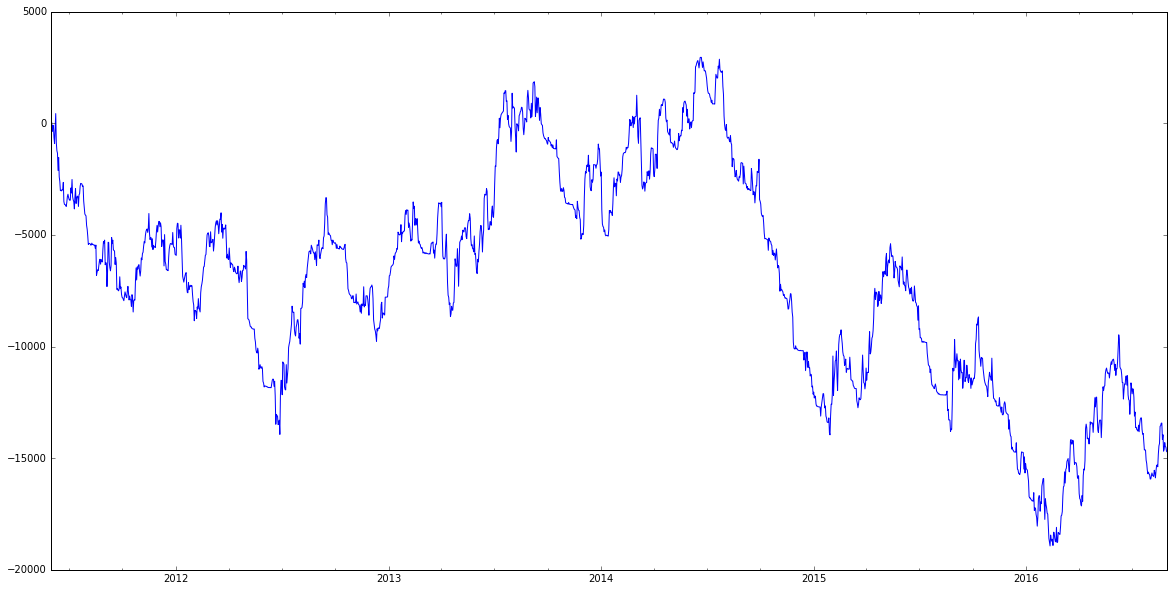

In [6]:
exo_series.plot()

In [7]:
swm_info = storage.swarms_info()
pp.pprint(swm_info)

{   '_id': None,
    'alphas': [   'MACross',
                  'RenkoPatterns_no_exit_on_patterns',
                  'VolatilityCompression',
                  'IchimokuCloud',
                  'PointAndFigurePatterns',
                  'SwingPoint',
                  'BollingerBands'],
    'exo_types': [   'BearishCollarBW',
                     'PutSpread',
                     'CallSpread',
                     'BullishCollarBW'],
    'instruments': ['NG', 'CL', 'ES']}


# Alphas as input

In [8]:
#instruments_filter = ['*']  # Select ALL
instruments_filter = ['CL']

exo_filter = ['*'] # Select ALL
#exo_filter = ['CallSpread']

#direction_filter = [0, -1, 1] # Select ALL
direction_filter = [1]

alpha_filter = ['*']  # Select ALL
#alpha_filter = ['MaCross', 'PointAndFigurePatterns']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)

In [9]:
df = swmdf

# Saved Swarm universes as input

In [815]:
df = pd.DataFrame()
exoname = 'CL'
direction = 'Long'
exostrategy = 'CallSpread'

for file in glob.glob("../swarms/*.swm"):
    swarmname = file.split('/')[-1]
    
    if (exoname in swarmname) and (direction in swarmname) and (exostrategy in swarmname):
        if df.size == 0:
            df = Swarm.load('../swarms/'+swarmname).raw_swarm
        else:
            df = pd.concat([df, Swarm.load('../swarms/'+swarmname).raw_swarm], axis=1)
    #print(file.split('/')[-1])
    #break

In [816]:
df.tail(10)

,"(1, 40, 30, 40)","(1, 40, 30, 50)","(1, 1, 1, 5)","(1, 1, 10, 5)","(1, 1, 2, 5)","(1, 1, 3, 5)","(1, 1, 4, 5)","(1, 1, 5, 5)","(1, 1, 6, 5)","(1, 1, 7, 5)",...,"(1, 90, 13, 26, 60, 5, 20)","(1, 90, 13, 26, 60, 5, 30)","(1, 90, 13, 26, 60, 6, 20)","(1, 90, 13, 26, 60, 6, 30)","(1, 90, 13, 26, 60, 7, 20)","(1, 90, 13, 26, 60, 7, 30)","(1, 90, 13, 26, 60, 8, 20)","(1, 90, 13, 26, 60, 8, 30)","(1, 90, 13, 26, 60, 9, 20)","(1, 90, 13, 26, 60, 9, 30)"
2016-08-21,1259.163515,4516.680338,11364.449877,1329.337426,4441.962183,12575.087911,9067.459467,11381.086199,9279.832037,5744.150269,...,840.884618,-1804.409651,-2977.575976,-15043.679485,-4745.416660,-12163.303203,4430.301435,211.90377,-4745.416660,-12163.303203
2016-08-22,1259.163515,4516.680338,10628.262438,593.149987,3705.774744,11838.900472,8331.272028,10644.898760,8543.644598,5007.962830,...,104.697179,-2540.597090,-3713.763415,-15779.866924,-5481.604099,-12899.490642,4430.301435,211.90377,-5481.604099,-12899.490642
2016-08-23,1259.163515,4516.680338,10628.262438,593.149987,3705.774744,11838.900472,8331.272028,10644.898760,8543.644598,5007.962830,...,317.271306,-2328.022962,-3501.189288,-15567.292797,-5269.029972,-12686.916515,4430.301435,211.90377,-5269.029972,-12686.916515
2016-08-24,1259.163515,4516.680338,9893.363390,-141.749061,2970.875696,11838.900472,7596.372980,9909.999712,7808.745550,4273.063782,...,-417.627742,-3062.922010,-4236.088336,-16302.191844,-6003.929020,-13421.815562,4430.301435,211.90377,-6003.929020,-13421.815562
2016-08-25,1259.163515,4516.680338,9984.161662,-50.950790,3061.673968,11838.900472,7687.171251,10000.797983,7899.543822,4363.862053,...,-326.829471,-2972.123739,-4145.290065,-16211.393573,-5913.130748,-13331.017291,4430.301435,211.90377,-5913.130748,-13331.017291
2016-08-26,1259.163515,4516.680338,10277.278483,242.166031,3354.790789,11838.900472,7980.288073,10293.914804,8192.660643,4656.978874,...,-33.712649,-2679.006918,-3852.173243,-15918.276752,-5620.013927,-13037.900470,4430.301435,211.90377,-5620.013927,-13037.900470
2016-08-27,1259.163515,4516.680338,10095.635722,60.523270,3173.148028,11838.900472,7798.645311,10112.272043,8011.017882,4475.336113,...,-215.355411,-2860.649679,-4033.816005,-16099.919513,-5801.656688,-13219.543231,4430.301435,211.90377,-5801.656688,-13219.543231
2016-08-28,1259.163515,4516.680338,10077.228241,42.115790,3154.740547,11838.900472,7780.237831,10093.864563,7992.610401,4456.928633,...,-233.762891,-2879.057159,-4052.223485,-16118.326993,-5820.064169,-13237.950711,4430.301435,211.90377,-5820.064169,-13237.950711
2016-08-29,1259.163515,4516.680338,9891.580826,-143.531625,2969.093132,11838.900472,7594.590416,9908.217148,7806.962986,4271.281218,...,-419.410306,-3064.704574,-4237.870900,-16303.974409,-6005.711584,-13423.598127,4430.301435,211.90377,-6005.711584,-13423.598127
2016-08-30,1259.163515,4516.680338,9863.217226,-171.895225,2940.729533,11838.900472,7566.226816,9879.853548,7778.599386,4242.917618,...,-419.410306,-3093.068174,-4237.870900,-16332.338008,-6005.711584,-13451.961726,4430.301435,211.90377,-6005.711584,-13451.961726


Up beta -5.057849607
Down beta -0.0909928631972


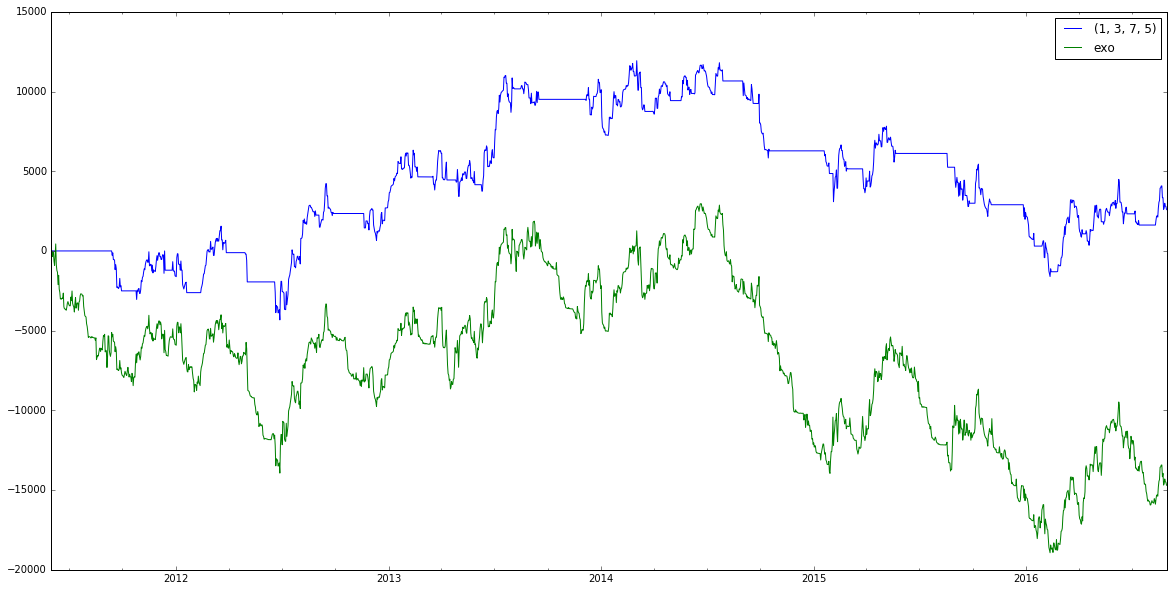

In [817]:
sample_strategy = df.sample(axis=1)
sample_strategy = sample_strategy[sample_strategy.columns[0]]

sample_strategy_pctchange = sample_strategy.pct_change(1).replace([np.inf, -np.inf], np.nan)
exo_series_pctchange = exo_series.pct_change(1).replace([np.inf, -np.inf], np.nan) 

sample_strategy_pos_pctchange = sample_strategy_pctchange[sample_strategy_pctchange > 0]
exo_series_pos_pctchange = exo_series_pctchange[exo_series_pctchange > 0]

sample_strategy_neg_pctchange = sample_strategy_pctchange[sample_strategy_pctchange < 0]
exo_series_neg_pctchange = exo_series_pctchange[exo_series_pctchange < 0]

pd.concat([sample_strategy, exo_series], axis=1).plot()


#(sample_strategy_pctchange.rolling(20).cov(exo_series_pctchange) / exo_series_pctchange.rolling(20).var()).rank(pct=True).plot(secondary_y=True)


# For longs
print('Up beta',sample_strategy_pos_pctchange.cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var())
print('Down beta',sample_strategy_neg_pctchange.cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var())

# For shorts
#print(sample_strategy_pos_pctchange.cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var())
#print(sample_strategy_neg_pctchange.cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var())

In [818]:
temp_l = []

for i in df.columns:
    
    strategy = df[i]
    
    strategy_pctchange = strategy.pct_change(1).replace([np.inf, -np.inf], np.nan)
    exo_series_pctchange = exo_series.pct_change(1).replace([np.inf, -np.inf], np.nan)
    
    
    strategy_pos_pctchange = strategy_pctchange[strategy_pctchange > 0]
    exo_series_pos_pctchange = exo_series_pctchange[exo_series_pctchange > 0]

    strategy_neg_pctchange = strategy_pctchange[strategy_pctchange < 0]
    exo_series_neg_pctchange = exo_series_pctchange[exo_series_pctchange < 0]

    # For longs

    d = {'strategy': i, 'up_beta': strategy_pos_pctchange.cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var(),
        'down_beta': strategy_neg_pctchange.cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var()}

    temp_l.append(d)
        #print(strategy_pos_pctchange.cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var())
        #print(strategy_neg_pctchange.cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var())
        
betas_df = pd.DataFrame(temp_l).dropna()
betas_df.set_index('strategy', inplace=True)

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [819]:
betas_df['betas_ratio'] = (betas_df.up_beta / betas_df.down_beta)

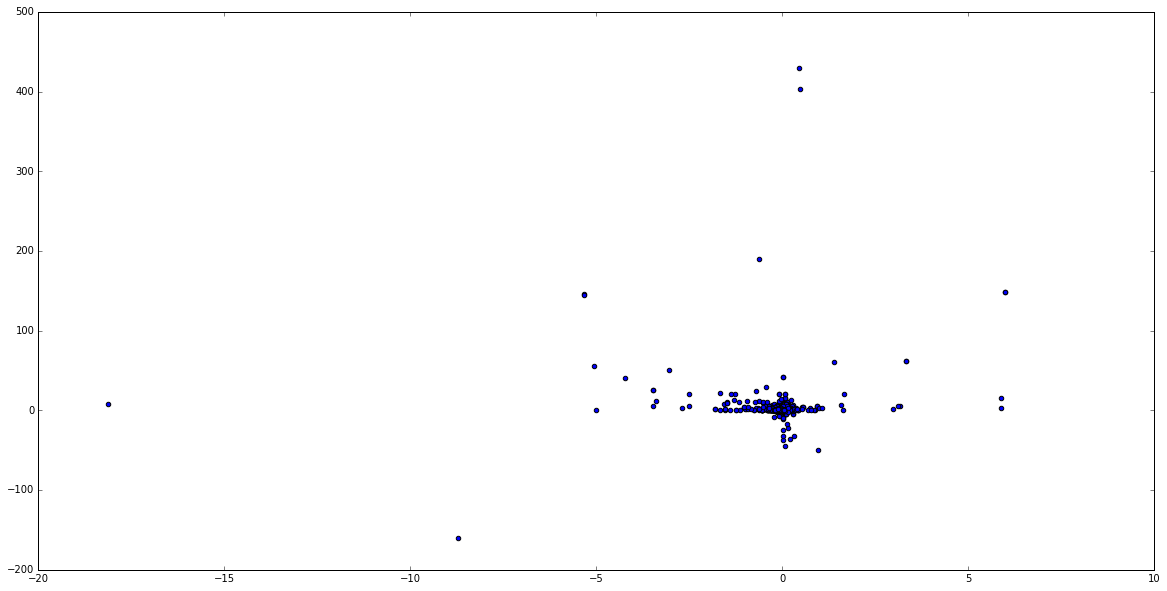

In [820]:
scatter(betas_df.up_beta, betas_df.betas_ratio)

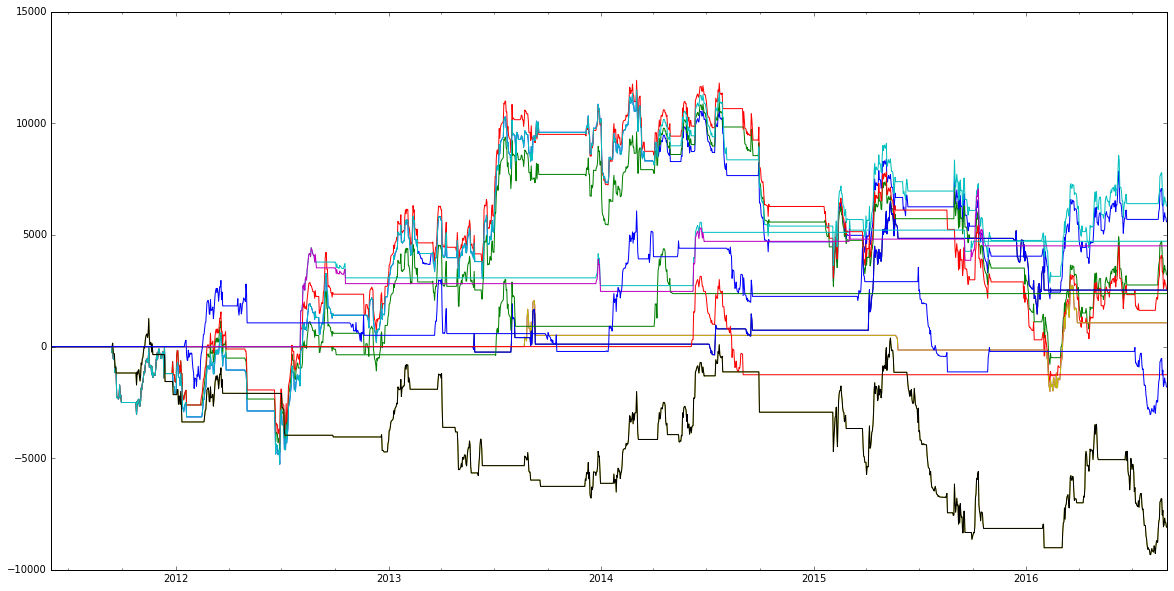

In [828]:
#df[(betas_df.up_beta[betas_df.up_beta > betas_df.up_beta.quantile(0.99)]).index].plot(legend=False)
#df[betas_df[(betas_df.down_beta < betas_df.down_beta.quantile(0.1)) & (betas_df.up_beta > betas_df.up_beta.quantile(0.9))].index].plot(legend=False)
df = df[betas_df[(betas_df.up_beta / betas_df.down_beta) > (betas_df.up_beta / betas_df.down_beta).quantile(0.99)].index]

df[betas_df[(betas_df.up_beta / betas_df.down_beta) >= (betas_df.up_beta / betas_df.down_beta).quantile(0.99) ].index].plot(legend=False)
#df[betas_df[betas_df.down_beta > betas_df.down_beta.quantile(0.)].index].plot()

In [829]:
betas_df.up_beta / betas_df.down_beta

strategy
(1, 40, 30, 40)                 22.073514
(1, 40, 30, 50)                  2.944777
(1, 1, 1, 5)                     4.717839
(1, 1, 10, 5)                    0.252755
(1, 1, 2, 5)                     2.151909
(1, 1, 3, 5)                     1.024415
(1, 1, 4, 5)                     0.355699
(1, 1, 5, 5)                     0.452171
(1, 1, 6, 5)                     1.111656
(1, 1, 7, 5)                     1.480022
(1, 1, 8, 5)                   146.609607
(1, 1, 9, 5)                     2.376401
(1, 10, 1, 5)                    0.847044
(1, 10, 10, 5)                   0.402733
(1, 10, 2, 5)                    1.401598
(1, 10, 3, 5)                    3.066576
(1, 10, 4, 5)                    0.849777
(1, 10, 5, 5)                    0.608494
(1, 10, 6, 5)                    3.167709
(1, 10, 7, 5)                    0.467033
(1, 10, 8, 5)                   20.419542
(1, 10, 9, 5)                    8.994207
(1, 11, 1, 5)                    2.429200
(1, 11, 10, 5)           

In [755]:
#((betas_df.up_beta[betas_df.up_beta > betas_df.up_beta.quantile(0.99)]) & 
#    (betas_df.down_beta[betas_df.down_beta < betas_df.down_beta.quantile(0.1)]))

#betas_df.up_beta[betas_df.up_beta > betas_df.up_beta.quantile(0.99)]
#betas_df[(betas_df.down_beta / betas_df.up_beta)]
(betas_df.up_beta / betas_df.down_beta).quantile(0.9)

59.759418656801842

## Drop all strategies which have rank score less than n predicted rating

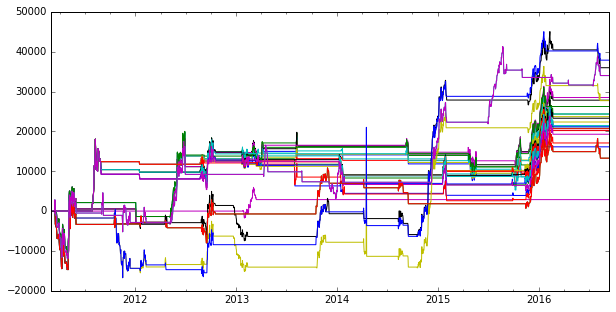

In [84]:
df.dropna().plot(legend=False)

## Filter those strategies by correlation

In [424]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rating', ascending=False).index, axis=1).dropna(axis=1).asfreq(BDay())

NameError: name 'strategies_performance_df' is not defined

In [88]:
df.corr()

strategy,"(-1, 30, 2, 0.05, 1, 0, 30)","(-1, 30, 3, 0.05, 1, 1, 50)","(-1, 40, 3, 0.05, 1, 0, 30)","(-1, 40, 2, 0.05, 1, 0, 40)","(-1, 40, 2, 0.05, 1, 0, 30)","(-1, 40, 4, 0.05, 1, 0, 40)","(-1, 40, 5, 0.05, 1, 0, 40)","(-1, 30, 5, 0.05, 1, 1, 50)","(-1, 30, 5, 0.05, 1, 1, 40)","(-1, 30, 5, 0.05, 1, 1, 30)",...,"(-1, 30, 5, 0.05, 1, 0, 30)","(-1, 30, 3, 0.05, 1, 1, 40)","(-1, 30, 3, 0.05, 1, 1, 30)","(-1, 50, 5, 0.05, 1, 0, 40)","(-1, 30, 2, 0.05, 1, 5, 30)","(-1, 30, 2, 0.05, 1, 1, 40)","(-1, 30, 2, 0.05, 1, 1, 30)","(-1, 50, 4, 0.05, 1, 0, 40)","(-1, 30, 3, 0.05, 1, 0, 40)","(-1, 30, 3, 0.05, 1, 0, 30)"
strategy,,,,,,,,,,,,,,,,,,,,,
"(-1, 30, 2, 0.05, 1, 0, 30)",1.000000,0.529385,0.452694,0.454916,0.373241,0.749212,0.749212,0.675604,0.714629,0.635766,...,0.984184,0.672835,0.358849,0.636509,0.646960,0.797337,0.718313,0.636509,0.972203,0.986085
"(-1, 30, 3, 0.05, 1, 1, 50)",0.529385,1.000000,0.183663,0.262555,0.199243,0.471641,0.471641,0.950668,0.927312,0.880280,...,0.533508,0.965243,0.939242,0.283435,0.031176,0.830989,0.800279,0.283435,0.527978,0.557951
"(-1, 40, 3, 0.05, 1, 0, 30)",0.452694,0.183663,1.000000,0.977196,0.985189,0.716527,0.716527,0.376421,0.413568,0.460540,...,0.577725,0.337366,0.104465,0.901537,0.562090,0.374558,0.406414,0.901537,0.601702,0.554191
"(-1, 40, 2, 0.05, 1, 0, 40)",0.454916,0.262555,0.977196,1.000000,0.981153,0.697301,0.697301,0.431886,0.473299,0.540908,...,0.576117,0.408586,0.222232,0.911898,0.473754,0.411515,0.468294,0.911898,0.593567,0.559931
"(-1, 40, 2, 0.05, 1, 0, 30)",0.373241,0.199243,0.985189,0.981153,1.000000,0.646967,0.646967,0.357826,0.387589,0.447740,...,0.499354,0.324987,0.149703,0.874724,0.425853,0.312493,0.359243,0.874724,0.521041,0.482579
"(-1, 40, 4, 0.05, 1, 0, 40)",0.749212,0.471641,0.716527,0.697301,0.646967,1.000000,1.000000,0.642922,0.675579,0.646985,...,0.822219,0.632826,0.307195,0.676236,0.641671,0.742492,0.713012,0.676236,0.843176,0.812748
"(-1, 40, 5, 0.05, 1, 0, 40)",0.749212,0.471641,0.716527,0.697301,0.646967,1.000000,1.000000,0.642922,0.675579,0.646985,...,0.822219,0.632826,0.307195,0.676236,0.641671,0.742492,0.713012,0.676236,0.843176,0.812748
"(-1, 30, 5, 0.05, 1, 1, 50)",0.675604,0.950668,0.376421,0.431886,0.357826,0.642922,0.642922,1.000000,0.993534,0.946921,...,0.697316,0.986269,0.842817,0.472752,0.292372,0.929075,0.892205,0.472752,0.698814,0.709157
"(-1, 30, 5, 0.05, 1, 1, 40)",0.714629,0.927312,0.413568,0.473299,0.387589,0.675579,0.675579,0.993534,1.000000,0.962326,...,0.738623,0.987515,0.826782,0.522792,0.341348,0.952513,0.924952,0.522792,0.739772,0.748234


In [89]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [90]:
df.corr()

strategy,"(-1, 30, 2, 0.05, 1, 0, 30)","(-1, 40, 3, 0.05, 1, 0, 30)","(-1, 30, 3, 0.05, 1, 1, 30)"
strategy,,,
"(-1, 30, 2, 0.05, 1, 0, 30)",1.000000,0.452694,0.358849
"(-1, 40, 3, 0.05, 1, 0, 30)",0.452694,1.000000,0.104465
"(-1, 30, 3, 0.05, 1, 1, 30)",0.358849,0.104465,1.000000


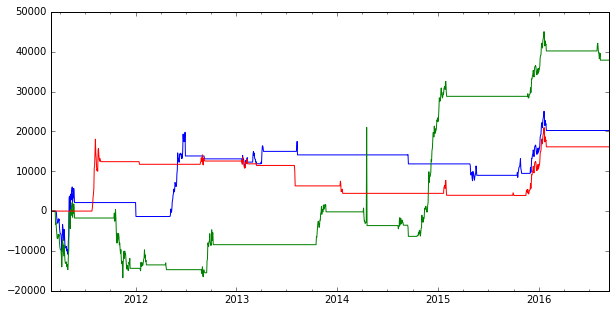

In [91]:
df.dropna().plot(legend=False)

# Metrics calculation

In [830]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate, 
                     'equity_below_zero': df[strat].ix[rebalance_date_start] < 0}
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [831]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [832]:
stats_df.tail(10)

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy
4100,False,2016-08-29,2016-08-22,274,-472.997894,-472.997894,-0.408248,0.000001,-1.000000,0.000001,"(1, 500, 3, 0.05, 1, 6, 40)"
4101,False,2016-08-29,2016-08-22,274,-1052.895874,407.782310,0.110806,1.362389,0.387296,71.428571,"(1, 700, 2, 0.05, 1, 4, 40)"
4102,False,2016-08-29,2016-08-22,274,-1052.895874,407.782310,0.110806,1.362389,0.387296,71.428571,"(1, 700, 2, 0.05, 1, 6, 40)"
4103,False,2016-08-29,2016-08-22,274,-675.029724,-400.813660,-0.249438,0.420686,-0.593772,28.571429,"(1, 800, 2, 0.05, 1, 3, 50)"
4104,True,2016-08-29,2016-08-22,274,-924.767883,-924.767883,-0.408248,0.000001,-1.000000,0.000001,"(1, 500, 4, 8, 20)"
4105,False,2016-08-29,2016-08-22,274,-309.828125,449.335523,0.302129,2.388064,1.450274,57.142857,"(1, 20, 13, 26, 60, 13, 20)"
4106,False,2016-08-29,2016-08-22,274,-234.970505,-234.970505,-0.408248,0.000001,-1.000000,0.000001,"(1, 20, 13, 26, 60, 13, 30)"
4107,True,2016-08-29,2016-08-22,274,-736.681612,-524.107485,-0.235429,0.532296,-0.711444,42.857143,"(1, 50, 13, 26, 60, 10, 30)"
4108,True,2016-08-29,2016-08-22,274,-736.681612,-524.107485,-0.235429,0.532296,-0.711444,42.857143,"(1, 50, 13, 26, 60, 8, 30)"
4109,True,2016-08-29,2016-08-22,274,-736.681612,-524.107485,-0.235429,0.532296,-0.711444,42.857143,"(1, 85, 13, 26, 60, 13, 30)"


## Statistics rank calculation

In [833]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

rebalance index --- 16
rebalance index --- 17
rebalance index --- 18
rebalance index --- 19
rebalance index --- 20
rebalance index --- 21
rebalance index --- 22
rebalance index --- 23
rebalance index --- 24
rebalance index --- 25
rebalance index --- 26
rebalance index --- 27
rebalance index --- 28
rebalance index --- 29
rebalance index --- 30
rebalance index --- 31
rebalance index --- 32
rebalance index --- 33
rebalance index --- 34
rebalance index --- 35
rebalance index --- 36
rebalance index --- 37
rebalance index --- 38
rebalance index --- 39
rebalance index --- 40
rebalance index --- 41
rebalance index --- 42
rebalance index --- 43
rebalance index --- 44
rebalance index --- 45
rebalance index --- 46
rebalance index --- 47
rebalance index --- 48
rebalance index --- 49
rebalance index --- 50
rebalance index --- 51
rebalance index --- 52
rebalance index --- 53
rebalance index --- 54
rebalance index --- 55
rebalance index --- 56
rebalance index --- 57
rebalance index --- 58
rebalance i

In [96]:
stats_df.tail(10)

,equity_below_zero,rebalance_date_end,rebalance_date_start,rebalance_index,stats_max_dd,stats_netprofit,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_winrate,strategy,rank_score
857,False,2016-08-22,2016-08-15,286,-2510.0,-2510.0,-0.665794,0.090580,-1.000000,20.0,"(-1, 30, 3, 0.05, 1, 1, 30)",13.0
858,False,2016-08-29,2016-08-22,287,-2510.0,-2510.0,-0.665794,0.090580,-1.000000,20.0,"(-1, 30, 2, 0.05, 1, 0, 30)",13.0
859,False,2016-08-29,2016-08-22,287,-1720.0,-370.0,-0.084074,0.784884,-0.215116,40.0,"(-1, 40, 3, 0.05, 1, 0, 30)",44.0
860,False,2016-08-29,2016-08-22,287,-2510.0,-2510.0,-0.665794,0.090580,-1.000000,20.0,"(-1, 30, 3, 0.05, 1, 1, 30)",13.0
861,False,2016-09-05,2016-08-29,288,-2510.0,-2510.0,-0.665794,0.090580,-1.000000,20.0,"(-1, 30, 2, 0.05, 1, 0, 30)",13.0
862,False,2016-09-05,2016-08-29,288,-1720.0,-370.0,-0.084074,0.784884,-0.215116,40.0,"(-1, 40, 3, 0.05, 1, 0, 30)",44.0
863,False,2016-09-05,2016-08-29,288,-2510.0,-2510.0,-0.665794,0.090580,-1.000000,20.0,"(-1, 30, 3, 0.05, 1, 1, 30)",13.0
864,False,2016-09-12,2016-09-05,289,-2510.0,-2510.0,-0.665794,0.090580,-1.000000,20.0,"(-1, 30, 2, 0.05, 1, 0, 30)",13.0
865,False,2016-09-12,2016-09-05,289,-1720.0,-370.0,-0.084074,0.784884,-0.215116,40.0,"(-1, 40, 3, 0.05, 1, 0, 30)",44.0
866,False,2016-09-12,2016-09-05,289,-2510.0,-2510.0,-0.665794,0.090580,-1.000000,20.0,"(-1, 30, 3, 0.05, 1, 1, 30)",13.0


### Strategies picker

In [834]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:3]
        
        picked_worst_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-3:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Comparing portfolios stats with benchmark(all strategies equity)

In [835]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

Portfolio name --- Best


PriceChange Mod. Sharpe -0.0131270533612
Netprofit -17283.6011546
Max DD -36656.0669342
Recovery Factor -0.471507245598
Profit factor 0.936409332019
Winrate 18.6136694135


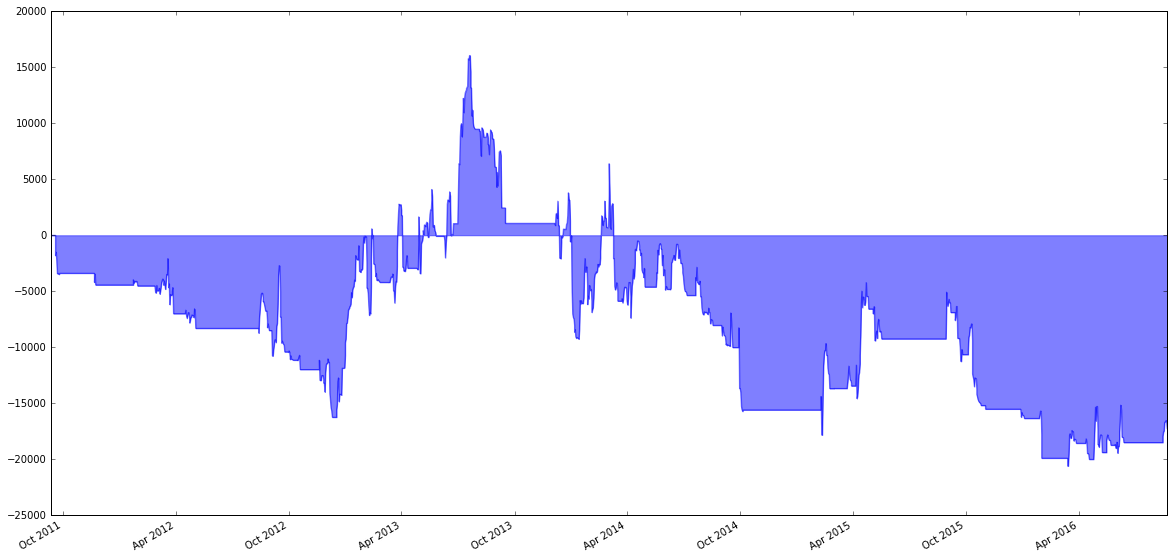

In [836]:
portfolio_stats(best_portfolio, 'Best')

Portfolio name --- Worst(reversed)


PriceChange Mod. Sharpe 0.0270221285349
Netprofit 19831.4031258
Max DD -13069.750414
Recovery Factor 1.51735132635
Profit factor 1.21028491669
Winrate 14.0087251575


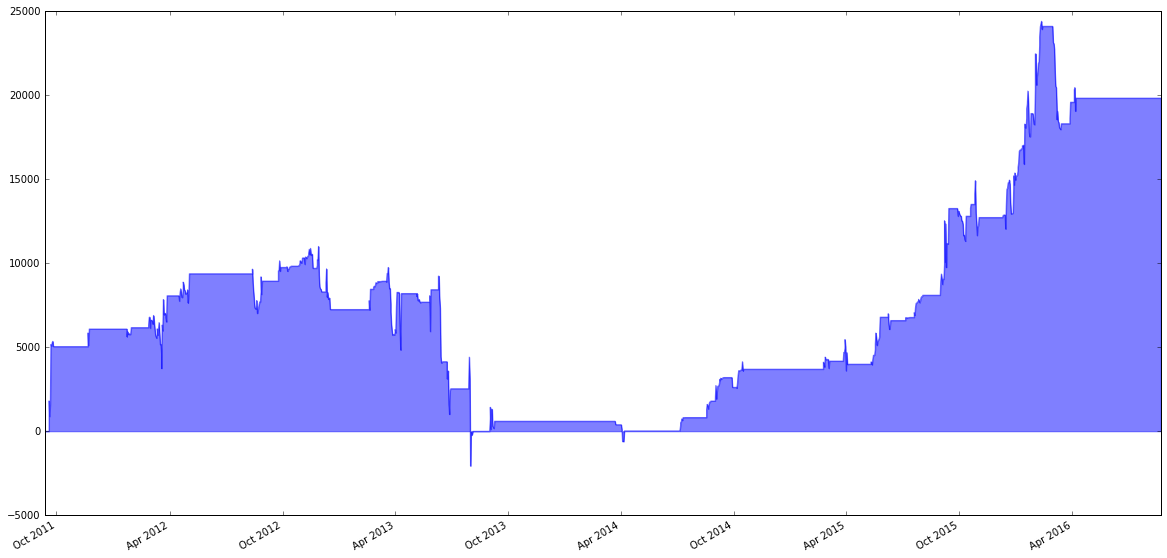

In [837]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

Portfolio name --- Summary(Best + Worst)


PriceChange Mod. Sharpe 0.00186953137761
Netprofit 2547.80197118
Max DD -32719.9303268
Recovery Factor 0.0778669742182
Profit factor 1.0090004926
Winrate 24.5758603975


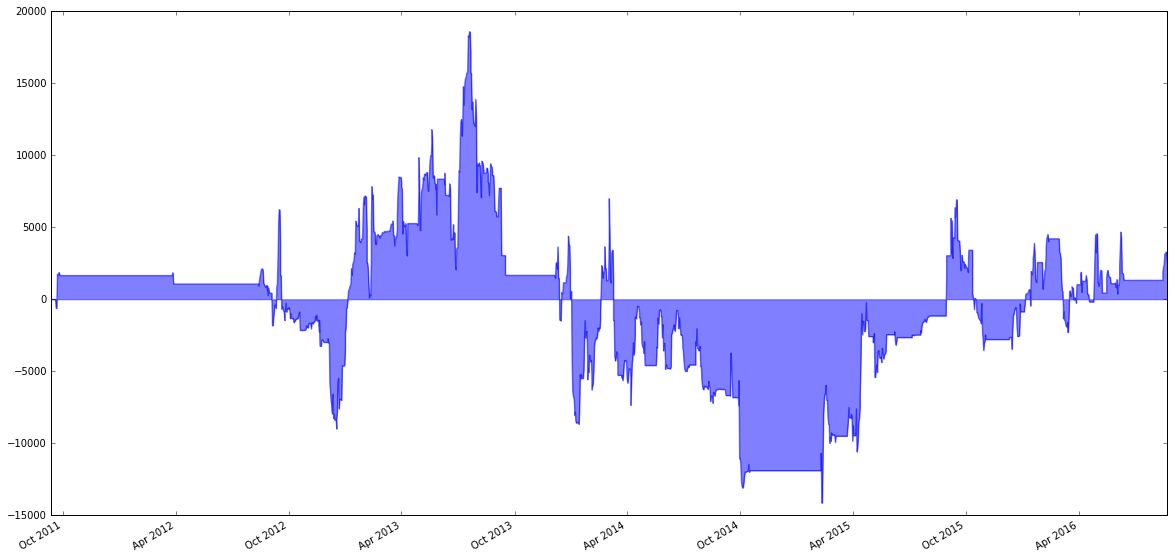

In [838]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

Portfolio name --- Benchmark(Trade all strategies)


PriceChange Mod. Sharpe -0.014238100694
Netprofit -52422.0131583
Max DD -110444.442755
Recovery Factor -0.474646001649
Profit factor 0.948675343005
Winrate 34.3189529811


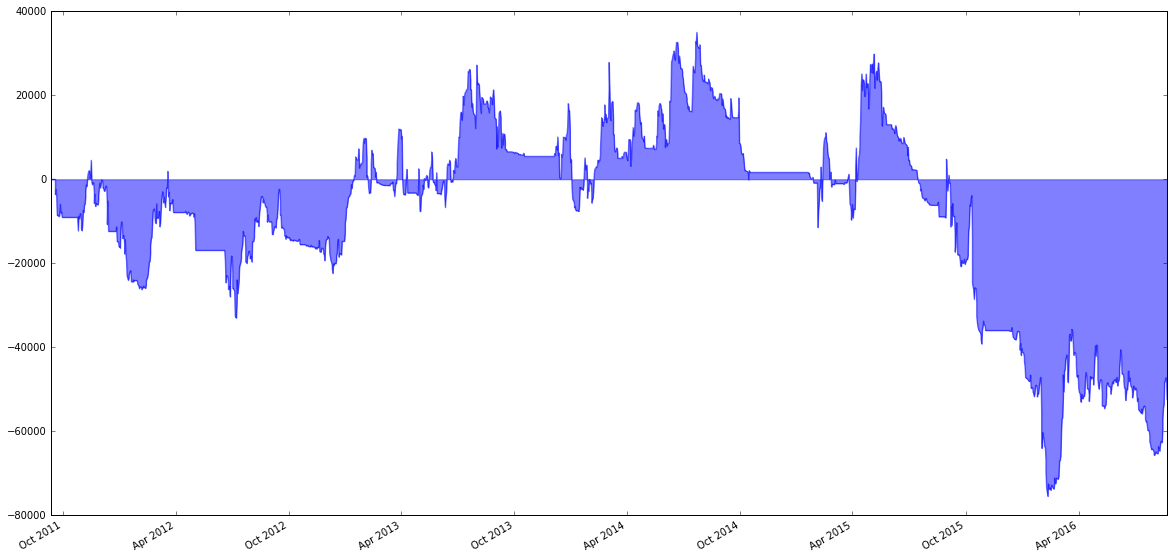

In [839]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [840]:
portfolio_stats(swarm.picked_equity, 'Picked swarm with current approach')

NameError: name 'swarm' is not defined